In [1237]:
import pandas as pd

data = pd.read_csv('combine.csv')
data.head()


,Month,.MMAX,.MMIN,..TMRF,.RH -0830,.RH -1730,dengue
0,1/1/2010,29.0,13.7,1.5,57,32,21
1,1/2/2010,32.0,15.9,0.0,52,26,15
2,1/3/2010,38.1,21.5,0.0,51,19,24
3,1/4/2010,41.7,25.9,0.0,56,22,45
4,1/5/2010,43.8,28.8,0.0,58,18,28


In [1238]:
data['Month'] = pd.to_datetime(data['Month'])
data = data.sort_values('Month')
data.set_index('Month', inplace=True)

data.head()


,.MMAX,.MMIN,..TMRF,.RH -0830,.RH -1730,dengue
Month,,,,,,
2010-01-01,29.0,13.7,1.5,57,32,21
2010-01-02,32.0,15.9,0.0,52,26,15
2010-01-03,38.1,21.5,0.0,51,19,24
2010-01-04,41.7,25.9,0.0,56,22,45
2010-01-05,43.8,28.8,0.0,58,18,28


In [1239]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Sklearn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)


Python: 3.10.19 (main, Oct  9 2025, 15:25:03) [Clang 17.0.0 (clang-1700.6.3.2)]
Pandas: 2.3.3
NumPy: 2.2.6
Sklearn: 1.7.2
TensorFlow: 2.20.0


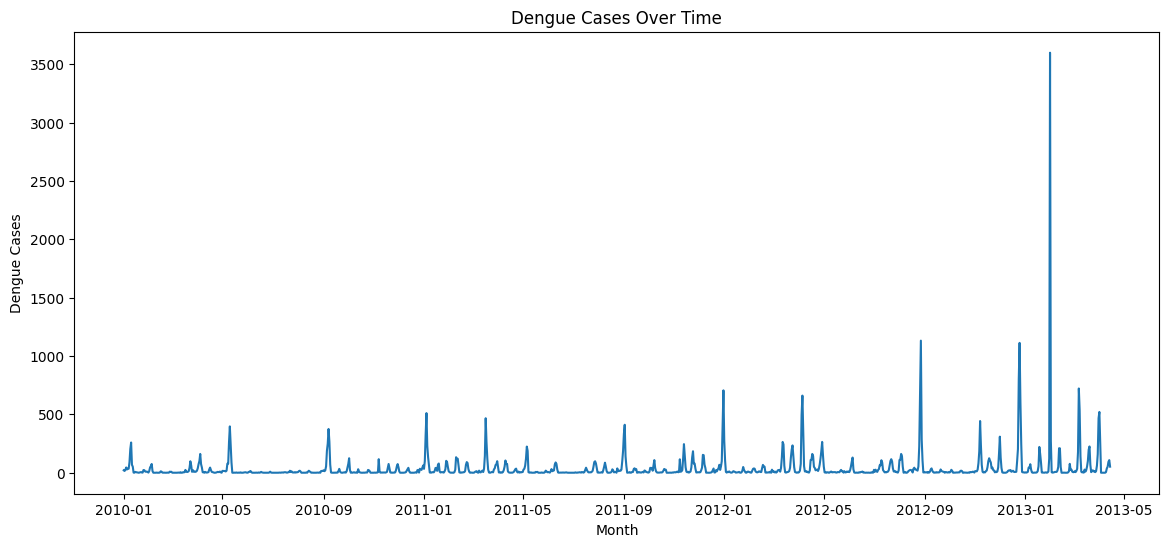

In [1240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(data['dengue'])
plt.title('Dengue Cases Over Time')
plt.xlabel('Month')
plt.ylabel('Dengue Cases')
plt.show()


In [1241]:
data['month'] = data.index.month

# Convert month to cyclic form
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)


In [1242]:
data['dengue_log'] = np.log1p(data['dengue'])

features = ['dengue_log', '.MMAX', '.MMIN', '..TMRF', '.RH -0830', '.RH -1730', 'month_sin', 'month_cos']
data_multi = data[features]


In [1243]:
# 1️⃣ First split RAW data (no scaling yet)
split = int(0.8 * len(data_multi))

train_data = data_multi[:split]
test_data  = data_multi[split:]

y_train_raw = data[['dengue_log']][:split]
y_test_raw  = data[['dengue_log']][split:]


# 2️⃣ Now scale using ONLY train data
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(train_data)
X_test_scaled  = scaler_X.transform(test_data)

y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)


# 3️⃣ Now make sequences
X_train, y_train = create_sequences_multivariate(X_train_scaled, y_train_scaled, 12)
X_test,  y_test  = create_sequences_multivariate(X_test_scaled,  y_test_scaled,  12)


In [1244]:
def create_sequences_multivariate(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_sequences_multivariate(X_scaled, y_scaled, time_steps=12)


In [1245]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import Huber

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(12, 8)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss=Huber())

model.summary()


/Users/omprakashsingh/Desktop/epidemic_prediction_system/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 12, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [1246]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0301 - val_loss: 0.0320
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - val_loss: 0.0243
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0136
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 6/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0111
Epoch 7/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0111
Epoch 8/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0103
Epoch 9/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 10/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0102
Epoch 11/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 12/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_lo

In [1247]:
predictions = model.predict(X_test)

predictions_actual = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

# convert log back to real dengue
predictions_actual = np.expm1(predictions_actual)
y_test_actual = np.expm1(y_test_actual)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


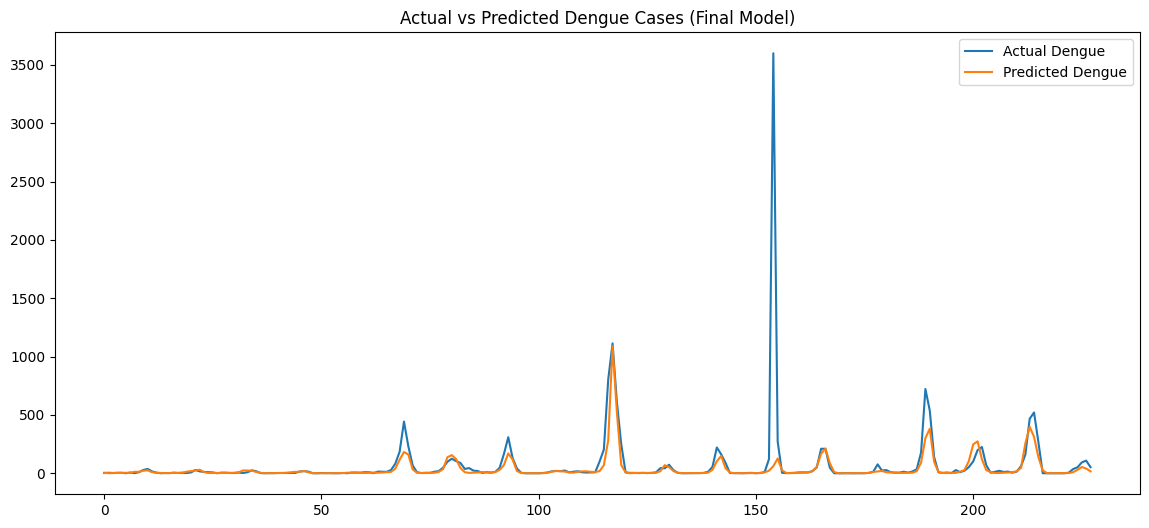

In [1248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Actual Dengue')
plt.plot(predictions_actual, label='Predicted Dengue')
plt.legend()
plt.title('Actual vs Predicted Dengue Cases (Final Model)')
plt.show()


In [1249]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)

mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
accuracy = 100 - mape

print("RMSE:", rmse)
print("MAE :", mae)
print("Accuracy:", accuracy, "%")


RMSE: 242.27955477345532
MAE : 38.33850483527703
Accuracy: -inf %


/var/folders/s_/j1djxxrs5fn0g2fgdnw3bgbc0000gn/T/ipykernel_1223/1615655045.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100


In [1250]:
import numpy as np

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

print("SMAPE:", smape(y_test_actual, predictions_actual), "%")


SMAPE: 81.43465486972555 %
